In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd # For csv
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle
import json

## Protein Disorder Prediction

### Data set-up

Import drive, so that DisProt.tsv can be read (assuming downloaded). Future adaption to use API to request TSV.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [3]:
def read_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_data.json', 'r') as infile:
    return json.load(infile)

def read_cleaned_pandas_data():
  return pd.read_json('/content/drive/My Drive/Colab Notebooks/diss_files/idr_pandas_table.json')

protein_sequences_n_ids = read_sequences()
fully_clean_pandas_data = read_cleaned_pandas_data()

Amino Acids Channeled Image

In [4]:
def make_empty_image(seq):
  img = {
    'A' : np.zeros(len(seq)),
    'C' : np.zeros(len(seq)),
    'D' : np.zeros(len(seq)),
    'E' : np.zeros(len(seq)),
    'F' : np.zeros(len(seq)),
    'G' : np.zeros(len(seq)),
    'H' : np.zeros(len(seq)),
    'I' : np.zeros(len(seq)),
    'K' : np.zeros(len(seq)),
    'L' : np.zeros(len(seq)),
    'M' : np.zeros(len(seq)),
    'N' : np.zeros(len(seq)),
    'P' : np.zeros(len(seq)),
    'Q' : np.zeros(len(seq)),
    'R' : np.zeros(len(seq)),
    'S' : np.zeros(len(seq)),
    'T' : np.zeros(len(seq)),
    'V' : np.zeros(len(seq)),
    'W' : np.zeros(len(seq)),
    'Y' : np.zeros(len(seq))
  }
  return img

def make_image(seq):
  # Makes 20 empty channels
  channeled_img = make_empty_image(seq)
  # Loop over each amino acid in the sequence - 
  # for its position add a 1 to the letter identifier channel
  for i, char in enumerate(seq):
    # Updates array due to arrays being like pointers
    channeled_img.get(char)[i] = 1

  return channeled_img

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [5]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, amino_map, protein_sequences, transform=None):
        self.disorder_prot = pandas_table
        self.sequence_map = make_image
        self.sequences = protein_sequences
        self.tranform = transform

    def __len__(self):
        return len(self.disorder_prot)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.disorder_prot['acc'].loc[idx]
        idrs = self.disorder_prot['disordered_regions'].loc[idx]
        
        # Get sequence
        protein_sequence = self.sequences.get(acc)
        # Vectorise amino acids
        protein_sequence_image = self.sequence_map(protein_sequence)
        # Converts channel dictionary to 2D array
        protein_sequence_image = np.array(list(protein_sequence_image.values()))
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'image': protein_sequence_image, 'label': disorder_label}
        return get_dict

### Training model, given DisProt dataset

Separate train/validation/test datasets. Currently using a 60/20/20 in place split from generated pandas data.

In [6]:
randomly_sampled_pandas_data = fully_clean_pandas_data.sample(frac = 1, random_state=117).reset_index()

train_len = round(len(randomly_sampled_pandas_data) * (60/100))
train_pandas_data = randomly_sampled_pandas_data[0:train_len]
train_dataset = DisProtDataset(train_pandas_data, make_image, protein_sequences_n_ids)

valid_len = round((len(randomly_sampled_pandas_data) * (20/100)))
valid_pandas_data = randomly_sampled_pandas_data[train_len:(train_len+valid_len)]
# Reset index helps clean up index column after slicing.
valid_pandas_data = valid_pandas_data.reset_index(drop=True)
validation_dataset = DisProtDataset(valid_pandas_data, make_image, protein_sequences_n_ids)

test_len = len(randomly_sampled_pandas_data) - (train_len + valid_len)
test_pandas_data = randomly_sampled_pandas_data[(train_len+valid_len):]
test_pandas_data = test_pandas_data.reset_index(drop=True)
test_dataset = DisProtDataset(test_pandas_data, make_image, protein_sequences_n_ids)

train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

MCC calculation.

In [7]:
# Turns the prediction to a list of ordered/disordered (0/1) predictions
def pred_round(predicted_label):
  predicted_label[predicted_label>=0.5] = 1
  predicted_label[predicted_label<0.5] = 0
  return predicted_label

def calc_MCC(predicted_label, true_label):
  # Calculating TN value
  # Sum as True values take on the value of 1
  TN = (true_label[predicted_label == 0] == 0).sum()
  # Calculating FN
  FN = (true_label[predicted_label == 0] == 1).sum()
  # Calculating TP
  TP = (true_label[predicted_label == 1] == 1).sum()
  FP = (true_label[predicted_label == 1] == 0).sum()
  #print("TP: ",TP,"\nFP: ",FP,"\nTN: ",TN,"\nFN: ",FN)

  num = (TP * TN) - (FP * FN)
  den = torch.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
  if den == 0:
    return 0
  MCC = num / den
  #print("MCC: ", MCC)
  return MCC

Counteracting the unbalanced dataset
- Generate a weight given the ratio of ordered to disordered amino acids.

In [8]:
def loss_weight_multiplier():
  total_amino_acids = 0
  total_disordered_AA = 0
  for i, sam in enumerate(train_loader):
    lab = torch.squeeze(sam.get('label'))
    total_amino_acids += len(lab)
    total_disordered_AA += sum(lab)

  disordered_ratio = total_disordered_AA / total_amino_acids
  disordered_loss_weight = 1 / disordered_ratio
  return disordered_loss_weight

### Working with a PyTorch NN. RNN model

In [9]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 20 inputs - for each amino acid
        self.input_dim = 20
        self.hidden_dim = 10
        self.num_layers = 2
        self.rnn1 = nn.LSTM(input_size=20, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.relu1 = nn.ReLU()
        self.linear = nn.Linear(10, 1)
        #self.sig1 = nn.Sigmoid()

    def init_hidden(self, batch_size):
        # Initialise hidden state
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda(), 
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda())

    def forward(self, x):
      batch_size = x.size(0)
      h    = self.init_hidden(batch_size)
      y, h = self.rnn1(x,h)

      y = self.relu1(y)
      
      #y = self.sig1(self.linear(y))
      y = self.linear(y)
      
      return y, h

Training loop for RNN model.
- Validation dataset used to monitor fit of model.
- Uses loss weights.

In [10]:
import datetime
epoch_print_gap = 20

def train_loop_rnn(n_epochs, optimizer, model, loss_fn, train_loader, valid_loader, device):
    model = model.to(device)
    for epoch in range(0, n_epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0

        # Creating an iterator jumbles the sequences order, so each accumulated batch will consider different 
        # sequences over many epochs
        train_iter = iter(train_loader)

        # Where i is a counter and sam is a dictionary
        for i, sam in enumerate(train_iter):
          acc, image, label = sam.values()
          # Einsum to flip axis dimensions suitable to rnn input
          image = torch.einsum('ijk->ikj', image)
          NN_input = image.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          output, _ = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          loss.backward()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()

          # This has effect of batches of size 16.
          # Don't have just i as when i is 0, this is true, therefore use i+1 and divisor 17.
          if (i+1) % 17 == 0:
            optimizer.step()
            optimizer.zero_grad()
          
          # Print loss throughout epoch.
          # Shows loss per 400 sequences of each epoch.
          # Only prints on print gap
          if epoch % epoch_print_gap == 0:
            if (i+1) % 400 == 0:
              print("Epoch: "+str(epoch), end=" ")
              # Average loss over these 400 sequences
              print("Current loss: "+str(running_loss_train / 400))
              running_loss_train = 0.0
        

        # Validation data handling
        valid_iter = iter(valid_loader)
        total_loss_valid = 0
        total_MCC_valid = 0
        for i, sam in enumerate(valid_iter):
          acc, image, label = sam.values()
          # Einsum to flip axis dimensions suitable to rnn input
          image = torch.einsum('ijk->ikj', image)
          NN_input = image.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          with torch.no_grad():
            output, _ = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          total_loss_valid += loss.item()

          total_MCC_valid += calc_MCC(pred_round(squeezed_o), squeezed_e_o)

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
            print("Epoch", epoch, "Done \n\n")

        epoch_loss_arr.append( (total_epoch_loss / len(train_loader)) )
        epoch_valid_loss_arr.append( (total_loss_valid / len(valid_loader)) )

        epoch_valid_MCC_arr.append( (total_MCC_valid / len(valid_loader)) )

# Main
lamb=0.001    # L2 weight decay term
lr = 0.001
epochs = 250
new_model = RNN_Net()
optimizer = optim.SGD(new_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

epoch_loss_arr = []
epoch_valid_loss_arr = []
epoch_valid_MCC_arr = []
train_loop_rnn(epochs, optimizer, new_model, criterion, train_loader, validation_loader, device)


Epoch: 0 Current loss: 1.497900779992342
Epoch: 0 Current loss: 1.3820248183608055
Epoch: 0 Current loss: 1.4055278313159942
Epoch 0 Done 


Epoch: 20 Current loss: 1.263526387065649
Epoch: 20 Current loss: 1.2864063708484172
Epoch: 20 Current loss: 1.3476155805587768
Epoch 20 Done 


Epoch: 40 Current loss: 1.2306630729138852
Epoch: 40 Current loss: 1.2623153902590274
Epoch: 40 Current loss: 1.2164966417849064
Epoch 40 Done 


Epoch: 60 Current loss: 1.2192812532186508
Epoch: 60 Current loss: 1.1925532692670822
Epoch: 60 Current loss: 1.1435235493630171
Epoch 60 Done 


Epoch: 80 Current loss: 1.1723632512241602
Epoch: 80 Current loss: 1.1447555565834044
Epoch: 80 Current loss: 1.16222302518785
Epoch 80 Done 


Epoch: 100 Current loss: 1.2031569630652665
Epoch: 100 Current loss: 1.1762153356522322
Epoch: 100 Current loss: 1.1657984636723995
Epoch 100 Done 


Epoch: 120 Current loss: 1.1848150189965962
Epoch: 120 Current loss: 1.144801225438714
Epoch: 120 Current loss: 1.13143758773803

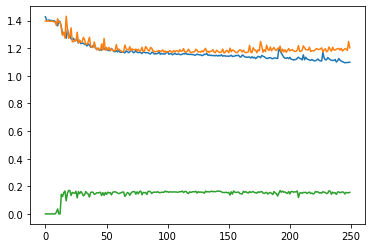

In [24]:
epoch_valid_MCC_arr_plottable = [epoch_valid_MCC_arr[i].to('cpu').numpy() if epoch_valid_MCC_arr[i] != 0 else 0.0 for i, se in enumerate(epoch_valid_MCC_arr)]

plt.plot(range(250), epoch_loss_arr)
plt.plot(range(250), epoch_valid_loss_arr)
plt.plot(range(250), epoch_valid_MCC_arr_plottable)
plt.show()

MCC for test dataset.

In [17]:
test_mcc_score = 0

for test_seq in test_loader:
  input_seq = test_seq.get('image')
  input_seq = torch.einsum('ijk->ikj', input_seq)
  input_seq = input_seq.type(torch.FloatTensor)
  input_seq = input_seq.to(device)
  true_label = test_seq.get('label')
  true_label = true_label.type(torch.FloatTensor)
  true_label = true_label.to(device)

  with torch.no_grad():
    predicted_label, _ = new_model(input_seq)

  predicted_label = torch.sigmoid(predicted_label)
  predicted_label = torch.squeeze(predicted_label)
  true_label = torch.squeeze(true_label)

  pred_lab = pred_round(predicted_label)
  test_mcc_score += calc_MCC(pred_lab, true_label)

  #break
print("Test MCC score: ", ( test_mcc_score / len(test_loader) ))

Test MCC score:  tensor(0.1749, device='cuda:0')


### Saving model

In [23]:
# Writes trained model to storage
def write_model(model):

  model = model.to("cpu")
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/rnn_net.pth'
  torch.save(model.state_dict(), PATH)

write_model(new_model)